# Gift Recommender Engine: Topic Classification Evaluation

This notebook outlines the approaches my attempts to evaluate the performance of my topic model on actual tweets. To get a sense of how my model is performing, I will test my classifier on the following tweets:

1. <b> Company Tweets </b>: This can be used as a proof-of-concept baseline test of the approach. Companies should be very distinct (ex. ESPN should predict sports, etc), so it may give a picture if the classifier is going on the right approach.
2. <b> Celebrity Tweets </b>: Celebrity's Tweets - we have some understanding of what a celebrity may or may not like (whether they are a singer, actor, or athlete). This way, we can test how the model is doing on specific users.


The implementation of the model on tweets can be outlined as followed:

1. Clean tweets using preprocessing function to remove links, stopwords, etc. 
2. Perform sentiment analysis on each tweet and filter tweets that contain positive sentiment. The idea here is that if a user tweets positively about something, that means they like that particular topic and can be gifted that item.
3. Input each tweet into the topic classifier, built out of a linear support vector classifier. Each tweet will generate a certain topic and a probability (i.e how confident the model is at predicting that particular topic).
4. Filter topics that have a confidence threshold greater than a certain point as to filter noise.
5. Count the most topics of tweets by the user. The top 3 topics will correspond to categories that the user might enjoy.

## Import Libraries, Functions, and Models

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Import Models

import pickle

# Naive Bayes Model
filename = open('models/nb_baseline2.sav', 'rb')
nb = pickle.load(filename)

# Support Vector Classifier Model
filename = open('models/linear_svc_baseline2.sav', 'rb')
ovr_svc = pickle.load(filename)

# Import Vectorizer
filename = open('models/tfidf_vectorizer2.sav', 'rb')
tfidf_model = pickle.load(filename)

# Import Reference Dictionary
filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

In [2]:
# Cleaning Functions

import re
import string
import nltk
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['im', "oh", "i'm", "lol", "gonna", 'ill'])
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def tweet_preprocess(text):
    text=re.sub(r'http\S+', '',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub('&lt;/?[a-z]+&gt;', '', text)
    text = text.replace('&amp', '&')
    text = re.sub(r"[^\w\s]", "", text)
    text = deEmojify(text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    #text = [re.sub('@[^\s]+','', s) for s in text] #remove @
    text = [s.lower() for s in text] #convert every character into lowercase
    #text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    text = ' '.join([s for s in text.split() if len(s) > 2])
    return text


class TweetCategory:

    def __init__(self, model, vectorizer, tweet_data, reference):
        self.data = tweet_data
        self.model = model
        self.vectorizer = vectorizer
        self.ref = reference
        self.analyzer = SentimentIntensityAnalyzer()

    def process_user_tweets(self):
        self.data['clean-tweet'] = self.data['Tweet Content'].map(tweet_preprocess)
        self.data = self.data[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

        self.data['vader-sentiment'] = self.data['tweet'].apply(lambda x: self.analyzer.polarity_scores(x))
        self.data['vader-pos'] = self.data['vader-sentiment'].apply(lambda x: x['pos'])
        self.data['vader-neu'] = self.data['vader-sentiment'].apply(lambda x: x['neu'])
        self.data['vader-neg'] = self.data['vader-sentiment'].apply(lambda x: x['neg'])
        self.data['vader-compound'] = self.data['vader-sentiment'].apply(lambda x: x['compound'])


    def predict_topics(self, sentiment_thresh, confidence_thresh):
        self.predict_df = self.data[(self.data['vader-compound'] >= sentiment_thresh) & (self.data['clean-tweet'] != '')]
        
        tweets_transformed = self.vectorizer.transform(self.predict_df['clean-tweet'])
        predicted_category = self.model.predict(tweets_transformed)

        p = np.array(self.model.decision_function(tweets_transformed))
        probability = np.exp(p)/np.sum(np.exp(p), axis=1, keepdims=True)
        probability_list = [max(prob) for prob in probability]

        self.predict_df['predicted'] = predicted_category
        self.predict_df['probability'] = probability_list
        self.predict_df['predicted'] = self.predict_df['predicted'].apply(lambda x: self.ref[x])

        top_categories = self.predict_df[self.predict_df['probability'] >= confidence_thresh]['predicted'].value_counts()[:3]       

        return top_categories

## Testing on Company Tweets

### 1. ESPN

If this model is valid, it should overwhelmingly categorize ESPN as a sports channel. Let's test this approach!

In [5]:
espn = pd.read_csv('datasets/twitter-profiles/report_espn/tweets.csv')
espn.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220229853557018625""",https://twitter.com/sportscenter/status/122022...,2020-01-23 06:20:42,"""“Coach, I can win the game for this team. Lea...",Retweet,Khoros,879,4845,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
1,"""1220226518712037376""",https://twitter.com/espn/status/12202265187120...,2020-01-23 06:07:27,"""Fans watching Zion go off in his first game 😮...",Tweet,Khoros,1682,8050,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected
2,"""1220214633442746369""",https://twitter.com/sportsnation/status/122021...,2020-01-23 05:20:13,"""Zion Williamson: 1 career game, 4 three-point...",Retweet,Khoros,2879,14761,"""21254264""","""SportsNation""",sportsnation,Verified,https://twitter.com/sportsnation,Not Protected
3,"""1220212122849857538""",https://twitter.com/espn/status/12202121228498...,2020-01-23 05:10:15,"""Zion put on a show in his NBA debut 🔥 https:/...",Tweet,Khoros,1821,12816,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected
4,"""1220208628751327232""",https://twitter.com/espn/status/12202086287513...,2020-01-23 04:56:22,"""ZION WENT OFF 😳\n\n17 points and 4/4 from dee...",Tweet,Khoros,3857,17229,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected


In [8]:
key = {v: k for k, v in ref.items()}

In [9]:
espn_model = TweetCategory(ovr_svc, tfidf_model, espn, key)
espn_model.process_user_tweets()
top_categories = espn_model.predict_topics(0, 0.2)

In [12]:
top_categories

Sports    590
Gamers     42
Music      18
Name: predicted, dtype: int64

In [32]:
espn_df = espn_model.predict_df
total_len = len(espn_df[espn_df.probability >= 0.2])

round(top_categories/total_len*100, 1)

Sports    83.6
Gamers     5.9
Music      2.5
Name: predicted, dtype: float64

The model overwhelmingly predicted sports! It's on the right track! Let's evaluate the model on other company platforms.

### 2. Youtube

This is a little bit tricky - Youtube can contain a variety of different platforms. If this model is valid, it should predict topics like movies and music. Weird topics will be books, alcohol, and travel.

In [29]:
youtube = pd.read_csv('datasets/twitter-profiles/report_youtube/tweets.csv')
youtube.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220238435861970944""",https://twitter.com/youtube/status/12202384358...,2020-01-23 06:54:48,"""Lunar New Year is almost here! 🧧🐭\nFind out w...",Tweet,Twitter Media Studio,105,636,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
1,"""1220140861486333952""",https://twitter.com/youtube/status/12201408614...,2020-01-23 00:27:05,"""Do it! https://t.co/FK8d5AEfzC""",Tweet,Twitter Web App,180,3651,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
2,"""1220133186048389121""",https://twitter.com/youtube/status/12201331860...,2020-01-22 23:56:35,"""@__gvby HI DAD!""",Reply,Twitter Web App,0,4,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
3,"""1220114272316878848""",https://twitter.com/youtube/status/12201142723...,2020-01-22 22:41:25,"""@DunkinJy OR do you know everything?""",Reply,Twitter Web App,0,2,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
4,"""1220051182338465792""",https://twitter.com/youtube/status/12200511823...,2020-01-22 18:30:43,"""So proud of you @nikkietutorials. 💞 Watch her...",Tweet,Twitter Media Studio,65,795,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected


In [30]:
youtube_model = TweetCategory(ovr_svc, tfidf_model, youtube, ref)
youtube_model.process_user_tweets()
top_categories = youtube_model.predict_topics(0, 0.2)
print(top_categories)

Movies    86
Music     71
Nature    60
Name: predicted, dtype: int64


Seems to predict movies and music quite well! Nature seems slightly odd, but let's have a look.

In [31]:
youtube_df = youtube_model.predict_df
youtube_df[(youtube_df['predicted'] =='Nature') & (youtube_df['probability']>=0.2)]['tweet'].to_list()[:30]

['"@fakeandie We leaf this🌿"',
 '"Get to know all about these good dogs with good jobs for Walk Your Dog Month. \n\nWatch the #YouTubeSocialImpact playlist made with @exploreorg: https://t.co/ezZtp3T3X2 https://t.co/iaubIeePEm"',
 '"YOU DID IT!!!!\n\n#TeamTrees has raised $20 million which means there will be 20 million trees planted! \n\nThank you @MrBeastYT, @MarkRober and all of the creators who made this a reality!🌲🌲🌲"',
 '"@kellum_bradley Baby animals are the BEST → https://t.co/B7It8PBjSx"',
 '"Bring on the sweaters! Check out these 20 winter fashion inspos by @kritikakhurana → https://t.co/2wUOxpH9tj https://t.co/RhZwK3JMuB"',
 '"@PiperPerabo @MrBeastYT @ThisIsZeroHour @sunrisemvmt @algore @GretaThunberg @MarkRuffalo @usclimatestrike @FortniteGame @SenBrianSchatz @teamtreesofficl Can\'t wait to see all of these 🌲grow!"',
 '"@Lethamyr_RL Looking green and leafy already #teamtrees 🌲"',
 '"@tobi Let\'s GROW! 🌲"',
 '"Creators started #TeamTrees with goal to raise $20M to plant 20M t

For the most part the tweets seem overwhelmingly about nature (raising money for Team Trees, recommending things about sustainability).

### 3. NASA

This may be a challenging one as well, but out of the categories, I will expect things like technology and nature. Completely wrong categories would be alcohol and household.

In [33]:
nasa = pd.read_csv('datasets/twitter-profiles/report_nasa/tweets.csv')
nasa.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220149150765002752""",https://twitter.com/nasa/status/12201491507650...,2020-01-23 01:00:01,"""Burn scars left by wildfires in southeastern ...",Tweet,Sprinklr,312,1192,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
1,"""1220126500843814912""",https://twitter.com/nasa/status/12201265008438...,2020-01-22 23:30:01,"""The search is on! Are you:\n\n☑️Curious about...",Tweet,Sprinklr,170,1098,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
2,"""1220124092336082946""",https://twitter.com/jimbridenstine/status/1220...,2020-01-22 23:20:27,"""The team has successfully lowered the @NASA_S...",Retweet,Twitter Web App,304,2107,"""243418245""","""Jim Bridenstine""",jimbridenstine,Verified,https://twitter.com/jimbridenstine,Not Protected
3,"""1220107625980973056""",https://twitter.com/nasa/status/12201076259809...,2020-01-22 22:15:01,"""To help return astronauts to the Moon, our #A...",Tweet,Sprinklr,454,2888,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
4,"""1220092526738247680""",https://twitter.com/nasa/status/12200925267382...,2020-01-22 21:15:01,"""The legacy of @NASASpitzer will live on! Afte...",Tweet,Sprinklr,662,3578,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected


In [40]:
nasa_model = TweetCategory(ovr_svc, tfidf_model, nasa, key)
nasa_model.process_user_tweets()
top_categories = nasa_model.predict_topics(0, 0.2)
print(top_categories)

Electronics/Gadgets    120
Nature                 104
Music                   17
Name: predicted, dtype: int64


In [ ]:
top_categories

In [41]:
nasa_df = nasa_model.predict_df
total_len = len(nasa_df[nasa_df.probability >= 0.2])

round(top_categories/total_len*100, 1)

Electronics/Gadgets    39.3
Nature                 34.1
Music                   5.6
Name: predicted, dtype: float64

The model predicts electronics and nature, which is very relevant! The next topic predicted is music, but this is 10 times less than the other two categories, which means it can very well be noise.

## Testing on Celebrity Tweets

### 1. Taylor Swift

If this model is working well, I would expect the model to predict mainly music. Other acceptable categories can be: movies (she starred in some movies, I believe she also recorded songs for a few movies), books, and nature (she has a cat!). Unacceptable categories may be business, alcohol, household, and coffee.

In [37]:
tswift = pd.read_csv('datasets/twitter-profiles/report_taylorswift13/tweets.csv')
tswift.head(5)

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1239670332958674944""",https://twitter.com/taylorswift13/status/12396...,2020-03-16 21:50:13,"""For Meredith, self quarantining is a way of l...",Tweet,Twitter for iPhone,27242,142398,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
1,"""1237360590110294016""",https://twitter.com/taylorswift13/status/12373...,2020-03-10 12:52:08,"""No one:\n\nAbsolutely no one:\n\nMe: here’s m...",Tweet,Twitter for iPhone,17683,123611,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
2,"""1236339640656973825""",https://twitter.com/taylorswift13/status/12363...,2020-03-07 17:15:15,"""In honor of International Women’s Day, I chan...",Tweet,Twitter for iPhone,13064,85267,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
3,"""1235917883726852098""",https://twitter.com/taylorswift13/status/12359...,2020-03-06 13:19:20,"""The Man Behind The Scenes - Becoming The Man ...",Tweet,Twitter for iPhone,11086,69057,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected
4,"""1234937694121287684""",https://twitter.com/taylorswift13/status/12349...,2020-03-03 20:24:24,"""My heart is with everyone in Tennessee who ha...",Tweet,Twitter for iPhone,14762,152138,"""17919972""","""Taylor Swift""",taylorswift13,Verified,https://twitter.com/taylorswift13,Not Protected


In [43]:
tswift_model = TweetCategory(ovr_svc, tfidf_model, tswift, key)
tswift_model.process_user_tweets()
top_categories = tswift_model.predict_topics(0, 0.2)
print(top_categories)

Music     39
Movies     7
Nature     3
Name: predicted, dtype: int64


In [44]:
tswift_df = tswift_model.predict_df
total_len = len(tswift_df[tswift_df.probability >= 0.2])

round(top_categories/total_len*100, 1)

Music     60.0
Movies    10.8
Nature     4.6
Name: predicted, dtype: float64

It predicts overwhelmingly music! Makes complete sense, since Taylor Swift is a musician and she promotes a lot of her music on Twitter.

### 2. The Ellen Show

This might be a bit challenging. I expect movies to be one of the categories predicted(includes TV show), since Ellen hosts a daytime interview show. Concerning topics might be electronics, sports, food, coffee, and household, since they are not very relevant.

In [45]:
ellen = pd.read_csv('datasets/twitter-profiles/report_theellenshow/tweets.csv')
ellen.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220160518394015744""",https://twitter.com/theellenshow/status/122016...,2020-01-23 01:45:11,"""Didn’t get to see my show today? You can watc...",Tweet,Twitter Web App,83,1221,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
1,"""1220144486359027712""",https://twitter.com/theellenshow/status/122014...,2020-01-23 00:41:29,"""My staff’s #TheBachelor Recap is really juicy...",Tweet,Twitter Web App,36,808,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
2,"""1220108865972260866""",https://twitter.com/theellenshow/status/122010...,2020-01-22 22:19:56,"""For those of you with your TVs on who are fee...",Tweet,Twitter Media Studio,590,8082,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
3,"""1220093866948214784""",https://twitter.com/theellenshow/status/122009...,2020-01-22 21:20:20,""".@NikkieTutorials is one of the most popular ...",Tweet,Twitter Media Studio,840,7990,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
4,"""1220072534076346369""",https://twitter.com/theellenshow/status/122007...,2020-01-22 19:55:34,"""For a lot of my staff, the 3-day weekend real...",Tweet,Twitter Media Studio,153,1813,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected


In [47]:
ellen_model = TweetCategory(ovr_svc, tfidf_model, ellen, key)
ellen_model.process_user_tweets()
top_categories = ellen_model.predict_topics(0, 0.2)
print(top_categories)

Movies    190
Gamers     62
Nature     46
Name: predicted, dtype: int64


In [48]:
ellen_df = ellen_model.predict_df
total_len = len(ellen_df[ellen_df.probability >= 0.2])

round(top_categories/total_len*100, 1)

Movies    39.6
Gamers    12.9
Nature     9.6
Name: predicted, dtype: float64

Predicted overwhelming movies! I was curious as to why it predicted Gaming and Nature, but I remembered Ellen has her own show about Games (Game of Games) and she plays a lot of games on her show with celebrities. Ellen is also an advocate for animals - she has the Ellen Wildlife Fund. Let's see if the tweets in these categories are in fact relevant!

In [42]:
ellen_df = ellen_model.predict_df

In [48]:
game_tweets = ellen_df[(ellen_df['probability'] >= 0.2) & (ellen_df['predicted'] == 'Gamers')]['tweet'].to_list()
nature_tweets = ellen_df[(ellen_df['probability'] >= 0.2) & (ellen_df['predicted'] == 'Nature')]['tweet'].to_list()

Overall, seems to do a pretty good job. A few misclassifications - fashion seems to be predicted as nature and a few sports (like congratulating Naomi Osaka) is predicted as games, but overall, the tweets are quite relevant.

### 3. Barack Obama

In [57]:
obama = pd.read_csv('datasets/twitter-profiles/report_barackobama/tweets.csv')
obama.head(5)

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1219267208250941440""",https://twitter.com/barackobama/status/1219267...,2020-01-20 14:35:29,"""Every so often, I re-read Dr. King’s Letter f...",Tweet,Twitter for iPhone,50301,239729,"""813286""","""Barack Obama""",barackobama,Verified,https://twitter.com/barackobama,Not Protected
1,"""1218174463046553600""",https://twitter.com/barackobama/status/1218174...,2020-01-17 14:13:19,"""In every scene, you are my star, @MichelleOba...",Tweet,Twitter for iPhone,394988,2758964,"""813286""","""Barack Obama""",barackobama,Verified,https://twitter.com/barackobama,Not Protected
2,"""1216725015695183872""",https://twitter.com/barackobama/status/1216725...,2020-01-13 14:13:44,"""Glad to see American Factory’s Oscar nod for ...",Tweet,Twitter for iPhone,11017,127215,"""813286""","""Barack Obama""",barackobama,Verified,https://twitter.com/barackobama,Not Protected
3,"""1216428587328458754""",https://twitter.com/barackobama/status/1216428...,2020-01-12 18:35:50,"""Our fellow Americans in Puerto Rico can use o...",Tweet,Twitter for iPhone,31512,135165,"""813286""","""Barack Obama""",barackobama,Verified,https://twitter.com/barackobama,Not Protected
4,"""1215378018790707205""",https://twitter.com/barackobama/status/1215378...,2020-01-09 21:01:14,"""Here’s the thing: Even with problems of this ...",Reply,Twitter for iPhone,6389,36772,"""813286""","""Barack Obama""",barackobama,Verified,https://twitter.com/barackobama,Not Protected


In [58]:
obama_model = TweetCategory(ovr_svc, tfidf_model, obama, ref)
obama_model.process_user_tweets()
top_categories = obama_model.predict_topics(0, 0.2)
print(top_categories)

Nature       128
Sports        34
Self-care     25
Name: predicted, dtype: int64


In [69]:
obama_df = obama_model.predict_df
nature_tweets = obama_df[(obama_df['predicted'] == 'Nature') & (obama_df['probability'] >= 0.2)]['tweet'].to_list()
sports_tweets = obama_df[(obama_df['predicted'] == 'Sports') & (obama_df['probability'] >= 0.2)]['tweet'].to_list()
care_tweets = obama_df[(obama_df['predicted'] == 'Self-care') & (obama_df['probability'] >= 0.2)]['tweet'].to_list()

In [72]:
print(nature_tweets[:30])
print(sports_tweets[:30])
print(care_tweets[:30])

['"The catastrophic fires in Australia are the latest example of the very real and very urgent consequences of climate change. It’s on us to stay focused and protect the one planet we’ve got for the next generation: https://t.co/dqytauPeXf"', '"In Vietnam I had the chance to sit down with some of our @ObamaFoundation leaders and alumni from across the Asia Pacific. From combating climate change in Vietnam to evaluating social impact in Indonesia, they\'re doing extraordinary work and expanding their impact together. https://t.co/3h2BiVzT2D"', '"One challenge will define the future for today’s young generation more dramatically than any other: Climate change. The millions of young people worldwide who’ve organized and joined today’s #ClimateStrike demand action to protect our planet, and they deserve it."', '"Just 16, @GretaThunberg is already one of our planet’s greatest advocates. Recognizing that her generation will bear the brunt of climate change, she’s unafraid to push for real ac

## Compute Similarity Scores

In [430]:
import gensim.downloader as api

model_glove_twitter = api.load("glove-twitter-25")

In [448]:
def get_similarity_score(row):
    doc = nlp(row['clean-tweet'])
    sim_score = list()
    
    for token in doc:
        if token.pos_ == 'NOUN':
            try:
                sim_score.append(model_glove_twitter.similarity(token.text, row['predicted'].lower()))
            except:
                sim_score.append(0)
    try:
        average = sum(sim_score)/len(sim_score)
    except:
        average = 0
    
    return average

def get_average_scores(df, conf_threshold):
    over_list = df[df.probability >= conf_threshold]['score'].to_list()
    under_list = df[df.probability < conf_threshold]['score'].to_list()
    
    ave_over = sum(over_list)/len(over_list) 
    ave_under = sum(under_list)/len(under_list) 
    
    return [ave_over, ave_under]

def get_results(all_df, conf_threshold):
    average_scores = list()
    for df in all_df:
        df.predict_df['score'] = df.predict_df.apply(get_similarity_score, axis=1)
        average_scores.append(get_average_scores(df.predict_df, conf_threshold))
    above = [i[0] for i in average_scores]
    below = [i[1] for i in average_scores]
    above_average = sum(above)/len(above)
    below_average = sum(below)/len(below)
    return [above_average, below_average]

In [463]:
all_df = [espn_model, youtube_model, nasa_model, tswift_model, ellen_model, obama_model]
all_averages = list()
threshold = np.linspace(0.1, 0.3, 11)

In [465]:
for prob in threshold:
    all_averages.append(get_results(all_df, prob))

In [467]:
average_df = pd.DataFrame(columns=['above', 'below'])
for i in all_averages:
    average_df.loc[len(average_df)] = i

In [468]:
average_df['threshold'] = threshold

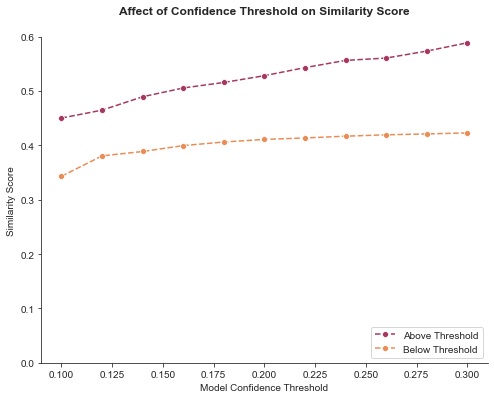

In [470]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x="threshold", y="above", data=average_df,
            label="Above Threshold", linestyle='--', marker='o', color='#a53860', ax=ax)
sns.lineplot(x="threshold", y="below", data=average_df,
           label="Below Threshold", linestyle='--', marker='o', color='#ea8c55', ax=ax)
plt.xlabel('Model Confidence Threshold')
plt.ylabel('Similarity Score')
ax.set_ylim([0, 0.6])
ax.set_title('Affect of Confidence Threshold on Similarity Score', fontweight='bold', fontsize=12, y=1.05)
plt.legend(loc='lower right')
sns.despine()

In [450]:
results = pd.DataFrame(averages).rename(columns={0: 'sim_score'})
results['threshold'] = ['Greater than 0.2', 'Less than 0.2']

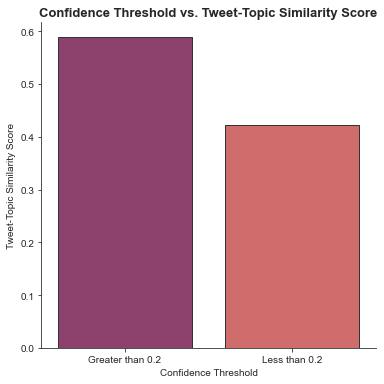

In [451]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_style('ticks')
sns.barplot(x='threshold', y='sim_score', data=results, palette='flare_r', edgecolor='.2')
plt.xlabel('Confidence Threshold')
plt.ylabel('Tweet-Topic Similarity Score')
plt.title('Confidence Threshold vs. Tweet-Topic Similarity Score', fontweight='bold', fontsize=13)
sns.despine()

## Evaluating Classifier Using Topic Modelling

Let's see if our model is able to capture the most predominant topics from a particular user by performing topic modelling on a user tweets. I will test this on Obama's Tweets.

In [313]:
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [419]:
ellen_tweets = ellen_df[['tweet', 'clean-tweet']]
#ellen_tweets['clean-tweet'] = ellen_tweets['tweet'].map(tweet_preprocess)

In [411]:
tfidf_v = TfidfVectorizer(stop_words='english')
tfidf=tfidf_v.fit_transform(ellen_tweets['clean-tweet'])
tfidf_feature_names=tfidf_v.get_feature_names()

In [420]:
count_v = CountVectorizer(stop_words='english')
count=count_v.fit_transform(ellen_tweets['clean-tweet'])
count_feature_names=count_v.get_feature_names()

In [423]:
no_topics=5
nmf=NMF(n_components=no_topics, random_state=1, alpha=0.1, l1_ratio=0.5, init='nndsvd')
lda=LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0)

In [427]:
nmf_output = nmf.fit_transform(tfidf)
lda_output = lda.fit_transform(tfidf)

In [428]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0:
right mood cute monday remember anytime bestcoverever adorable guy star vlog cover stan ooh shoutout iconic spider proud search wild
Topic 1:
wait work hole try youtube rabbit video sunday home know watch sweet think relax need hear far million hungry hit
Topic 2:
yes love thank good look welcome need sound great like tell song dance choice truly make extra night perfect youtube
Topic 3:
happy teamtree congratulation way birthday wooah congrat house exactly pls pancake yesssss believe fridayfeele agree upload store lifetime picture lie
Topic 4:
watch youtube video creator new make live today time like day send check year know follow favorite playlist learn come


In [429]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
youtube video creator make new today happy favorite good feature day year learn subscribe playlist createblackhistory check come music share
Topic 1:
yes teamtree say gross tip comeback marc shibsib worried fluff unfortunately new really saveyourinternet kind channel whotheme log yule nose
Topic 2:
love song favorite work minute idea hear luca monkey ryan elle great channel resource maddie anytime job slow feel surprise
Topic 3:
thank share patience story teamtree fix work sharing pls look hey inspire think role want wish community inspiration help stop
Topic 4:
watch live stop video youtube episode time happen brit ready need free glam tonight hour playlist friday streaming late trailer


#### Only Nouns

In [394]:
nlp = spacy.load("en_core_web_sm")

def get_nouns(text):
    doc = nlp(text)
    nouns = list()
    for token in doc:
        if token.pos_ == 'NOUN':
            nouns.append(str(token))
    return ' '.join(nouns)

In [395]:
ellen_tweets['nouns'] = ellen_tweets['clean-tweet'].map(get_nouns)

In [396]:
ellen_tweets.shape

(2811, 3)

In [357]:
ellen_tweets = ellen_tweets[ellen_tweets['nouns'] != '']

In [397]:
tfidf_v = TfidfVectorizer(stop_words='english')
tfidf=tfidf_v.fit_transform(ellen_tweets['nouns'])
tfidf_feature_names=tfidf_v.get_feature_names()

In [406]:
no_topics=3
nmf=NMF(n_components=no_topics, random_state=1, alpha=0.1, l1_ratio=0.5, init='nndsvd')
lda=LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0)

In [407]:
nmf_output = nmf.fit_transform(tfidf)
lda_output = lda.fit_transform(tfidf)

In [408]:
no_top_words = 20
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
birthday hope year people party world place husband suit gift know start tweet thank foot gyllenhaal dream queen night bear
Topic 1:
day today gift win season giveaway time audience chance year thankssponsor podcast friend dog video way spa ellenonthego surprise host
Topic 2:
love people gameofgame friend game thankssponsor thing time watch family tonight video today season lot play episode song holiday way


In [409]:
display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0:
audience story surprise performance hand dog hour man superbowl boy wish deck camera ohship burn morning apple wonder talent joy
Topic 1:
day season today thankssponsor watch gift episode tomorrow way tonight week video night burningquestion dance fun holiday host ellenonthego chance
Topic 2:
birthday love gameofgame time game people thing friend year hope lot world thankssponsor play family app today baby movie life


## Testing on Random User Data

In [75]:
df = pd.read_csv('datasets/kaggle-tweets-users150.csv')
df = df[['user', 'text']].rename(columns={'text': 'Tweet Content'})

### Random User 1

In [86]:
user1_df = df[df.user == 'SongoftheOss']

In [88]:
user1_model = TweetCategory(ovr_svc, tfidf_model, user1_df, ref)
user1_model.process_user_tweets()
top_categories = user1_model.predict_topics(0, 0.2)
print(top_categories)

Self-care    4
Food         3
Music        2
Name: predicted, dtype: int64


In [100]:
user1_df = user1_model.predict_df

In [110]:
self_care = user1_df[(user1_df['probability'] >= 0.2) &(user1_df['predicted'] =='Self-care')]['tweet'].to_list()
food = user1_df[(user1_df['probability'] >= 0.2) &(user1_df['predicted'] =='Food')]['tweet'].to_list()
music = user1_df[(user1_df['probability'] >= 0.2) &(user1_df['predicted'] =='Music')]['tweet'].to_list()
print(self_care)
print(food)
print(music)

['@cakey @Jayne0807 and hello there - massage oil? honestly I am shocked...  x', '@Applecored @thisstarchild lawks! think I will need to up my vitamin intake ', '@streetpete thanks you, so glad people like the choices - makes me think a lifetime of loving music is not wasted ', '@LadyCruella sleep well you ']
["@ms_cornwall ooh BBQ, OK just get me a few aberdeen angus burgers, that'll do me ", '@the_apostate er, yes of course, actually beetroot  ate way way too much salad at the weekend - contains carcinogens you know...', 'I hope @thisstarchild has not been fried sunbathing ']
['fantastic song  ? http://blip.fm/~7aaxh', 'Such a great song, why not more choices for it  â\x99« http://blip.fm/~7gepn']


### Random User 2

In [114]:
user2_df = df[df.user == 'shanajaca']

In [115]:
user2_model = TweetCategory(ovr_svc, tfidf_model, user2_df, ref)
user2_model.process_user_tweets()
top_categories = user2_model.predict_topics(0, 0.2)
print(top_categories)

Movies    3
Art       2
Food      2
Name: predicted, dtype: int64


User tweets from this dataset does not look good - it appears to be comments. I will try scraping Twitter to get real users tweets.